# Fine-Tune MobileNetV3 for Rotten vs Fresh Classification
This notebook loads the cleaned dataset, fine-tunes the last layer of MobileNetV3 for binary classification, and demonstrates inference on a sample image.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-07-01 09:56:23.006756: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 09:56:23.007808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 09:56:23.010898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-01 09:56:23.019716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751363783.034834  204541 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751363783.03

## Set up data generators

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
DATA_DIR = './processed_data'

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=20)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 20433 images belonging to 2 classes.
Found 1535 images belonging to 2 classes.
Found 1535 images belonging to 2 classes.


## Load MobileNetV3 and fine-tune last layer

In [3]:
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-07-01 09:56:45.010604: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,013,105 (3.86 MB)

 Trainable params: 73,985 (289.00 KB)

 Non-trainable params: 939,120 (3.58 MB)

## Train the model

In [5]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6564 - loss: 0.6489

/home/ubuntu/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 192s 295ms/step - accuracy: 0.6564 - loss: 0.6489 - val_accuracy: 0.8046 - val_loss: 0.5752
Epoch 2/10
Epoch 2/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 186s 292ms/step - accuracy: 0.6551 - loss: 0.6311 - val_accuracy: 0.8046 - val_loss: 0.6040
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 186s 292ms/step - accuracy: 0.6551 - loss: 0.6311 - val_accuracy: 0.8046 - val_loss: 0.6040
Epoch 3/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 187s 293ms/step - accuracy: 0.6564 - loss: 0.6197 - val_accuracy: 0.8046 - val_loss: 0.5339
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 187s 293ms/step - accuracy: 0.6564 - loss: 0.6197 - val_accuracy: 0.8046 - val_loss: 0.5339
Epoch 4/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 188s 294ms/step - accuracy: 0.6681 - loss: 0.5962 - val_accuracy: 0.8150 - val_loss: 0.4862
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 188s 294ms/step - accuracy: 0.6681 - loss: 0.5962 - val_accuracy: 0.8150 - val_loss: 0.4862
Epoch 5/10
639/639 ━━━━━━━━━━━━━━━━━━━━ 188s 294ms/step - accuracy: 0.6850 -

## Plot training history

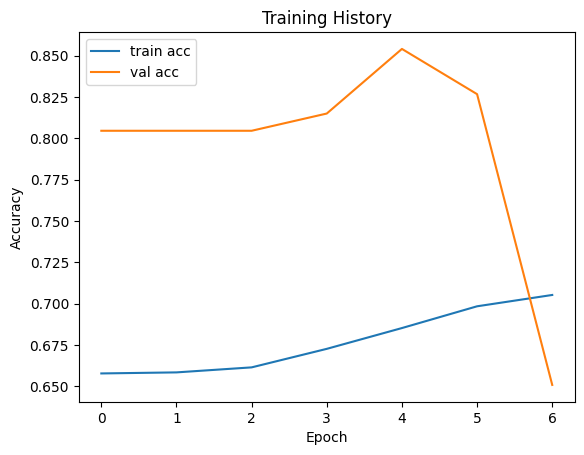

In [6]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training History')
plt.show()

## Inference Example
Test the model on a random image from the test set.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


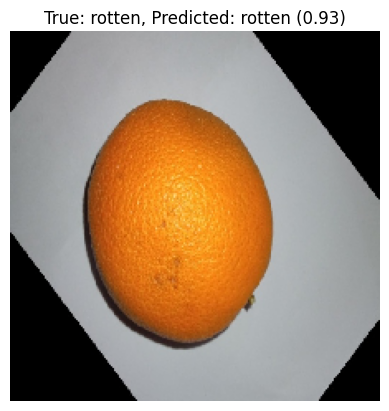

In [7]:
import random
from tensorflow.keras.preprocessing import image

# Pick a random test image
test_rotten = os.listdir(os.path.join(DATA_DIR, 'test', 'rotten'))
test_fresh = os.listdir(os.path.join(DATA_DIR, 'test', 'fresh'))
all_test = [(f, 'rotten') for f in test_rotten] + [(f, 'fresh') for f in test_fresh]
img_name, label = random.choice(all_test)
img_path = os.path.join(DATA_DIR, 'test', label, img_name)

img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
pred = model.predict(img_array)[0][0]

plt.imshow(img)
plt.axis('off')
pred_label = 'rotten' if pred > 0.5 else 'fresh'
plt.title(f"True: {label}, Predicted: {pred_label} ({pred:.2f})")
plt.show()

In [8]:
# Save the trained model to an H5 file
model.save('mobilenetv3_rotten_fresh.h5')
print('Model saved as mobilenetv3_rotten_fresh.h5')

Model saved as mobilenetv3_rotten_fresh.h5
